# Numerical Calculation and plotting of the Fixation Probability for meta-star 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [12]:
local_size = 5   # population size in each patch
number_of_patches = 4 # number of patches
migration_probability = [0.000001,0.01,0.1,0.5,1] 
Fitness = np.linspace(0.1,2.,20)
Fitness1 = np.linspace(0.1,2,100)

**Define the adjacency matrix of star graph**

In [ ]:

def star(number_of_patches):
    """
    Return the adjacency matrix of a star graph with a given number of patches.

    Parameters
    ----------
    number_of_patches : int
        The number of patches in the star graph.

    Returns
    -------
    numpy.ndarray
        The adjacency matrix of the star graph.
    """
    S = np.zeros([number_of_patches, number_of_patches])
    S[:, number_of_patches - 1] = 1
    S[number_of_patches - 1, :] = 1
    S[number_of_patches - 1, number_of_patches - 1] = 0
    return S


In [14]:
# Compute the adjacency matrix of a star graph with the given number of patches
adjacency_matrix = star(number_of_patches)

# Calculate the in-degree of each vertex in the graph
degree_vertices = np.sum(adjacency_matrix, axis=1)

# Calculate the number of possible states that an evolutionary trajectory could go through
# starting from one mutant to extinction or fixation
number_of_states = (local_size + 1) ** patch_number

**A function that take the state and returns the configuration of the meta-population**

In [ ]:
def convert_to_base(decimal_number, base, number_of_patches):
    """
    Convert a decimal number to a number with arbitrary base.

    Parameters
    ----------
    decimal_number : int
        The decimal number to be converted.

    base : int
        The base to which the decimal number will be converted.

    number_of_patches : int
        Number of patches     

    Returns
    -------
    list
        A list representing the converted number in the specified base.
    """
    remainder_stack = []
    while decimal_number > 0:
        remainder = decimal_number % base
        remainder_stack.append(remainder)
        decimal_number = decimal_number // base
    # Pad the remainder stack with zeros to match the number of patches
    remainder_stack += [0] * number_of_patches
    # Trim the remainder stack to the desired length
    remainder_stack = remainder_stack[:number_of_patches]
    return remainder_stack



**The transition matrix**

Each state is represented by a list $[i_1, i_2, i_3, ...]$ where $i_n$ is the number of mutants on the patch $n$. $i_n$ can vary between 0 and local_size (here shown as $M$). The number of mutants at the whole graph can only increase or decrease by one at each transition and the transition stops until all the network is either occupied by mutants (fixation state) or by wild-types (extinction step). An increase in the number of mutants occures when a mutant is chosen to give birth and replaces a wild-type either on the same patch or on an adjacent patch. 
As an example the number of mutants in patch 1, i.e. $i_1$ transitions to $i_1 + 1$ with the following probability:

$ T[(i_1, i_2,...), (i_1+1, i_2,...)] = \sum_n A[n, 1]\dfrac{ri_n}{ F_t} \dfrac{M - i_1}{M} $
where $A$ is the adjacent matrix of the network, $r$ is the relative fitness of the mutant, $M$ is the local population size, and $F_t$ is the total fitness of the population.

In [ ]:

def transition_matrix(adjacency_matrix, fitness, number_of_states, number_of_patches, local_size):
    """
    Compute the transition matrix of an evolutionary network-structured metapopulation
    when local population size is identical in all the patches.

    Parameters
    ----------
    adjacency_matrix : numpy.ndarray
        The adjacency matrix representing connectivity between patches.

    fitness : float
        The fitness value.

    number_of_states : int
        The number of possible states in the evolutionary trajectory.

    number_of_patches : int
        The number of patches in the metapopulation.

    local_size : int
        The local population size.

    Returns
    -------
    numpy.ndarray
        The transition matrix of the metapopulation.
    """
    T = np.zeros([number_of_states, number_of_states])
    for i in range(number_of_states):
        # Convert i to the base of local_size to get the configuration on the graph as a list
        i_config = convert_to_base(i, local_size + 1, number_of_patches)
        # Calculate the total fitness
        total_fitness = fitness * sum(i_config) + number_of_patches * local_size - sum(i_config)
        
        for n in range(number_of_patches):
            # The probability that the number of mutants in patch n increases by one
            if i + (local_size + 1) ** n < number_of_states: 
                for k in range(number_of_patches):
                    T[i, i + (local_size + 1) ** n] += fitness * adjacency_matrix[k, n] * i_config[k]
                T[i, i + (local_size + 1) ** n] *= (local_size - i_config[n]) / (local_size * total_fitness)    

            # The probability that the number of mutants in patch n decreases by one    
            if i - (local_size + 1) ** n >= 0:
                for k in range(number_of_patches):
                     T[i, i - (local_size + 1) ** n] += adjacency_matrix[k, n] * (local_size - i_config[k])
                T[i, i - (local_size + 1) ** n] *= i_config[n] / (local_size * total_fitness)      
                             
    # Calculate the diagonal elements of the transition matrix
    for i in range(number_of_states):
        T[i, i] = 1 - T[i].sum()
        
    return T 


#### calculating the fixation probability
In order to calculate the mean fixation probability strating from one mutant on the network, we make use of the following formula:

$\phi= (Q-I)^{-1}R$. 

In this relation $\phi$ is the absorption probability from any state to one of the absorbing points (either extinction or fixation).
$Q$ is the transition matrix between transient states. $I$ is the identity matrix and $R$ represent the probability of transition from any transient states to absorbing states. 

In order to compute the fixation probability from this formula we sum over the entries of the matrix which determine the probability going from one mutant to the fixation state.

In [17]:
def fixation_probability(migration_probability, fitness, number_of_states, number_of_patches, local_size):
    """
    Calculate the fixation probability of mutants in a metapopulation.

    Parameters
    ----------
    migration_probability : float
        The probability of migration between patches.

    fitness : float
        The fitness value.

    number_of_states : int
        The number of possible states in the evolutionary trajectory.

    number_of_patches : int
        The number of patches in the metapopulation.

    local_size : int
        The local population size.

    Returns
    -------
    float
        The fixation probability of mutants.
    """
    # Compute the transition matrix
    TM = transition_matrix(migration_probability, fitness, number_of_states, number_of_patches, local_size)
    
    # Extract submatrices
    Q = TM[1:number_of_states-1, 1:number_of_states-1]
    a = TM[1:number_of_states-1, 0]
    b = TM[1:number_of_states-1, number_of_states-1]
    
    # Concatenate matrices
    R = np.concatenate((a, b), axis=0)
    R = np.transpose(R.reshape((2, number_of_states-2)))
    
    # Identity matrix
    Identity = np.identity(number_of_states-2)

    # Calculate the inverse of (Identity - Q)
    inverse = np.linalg.inv(Identity - Q)
    
    # Calculate Probability = inverse * R
    Probability = np.dot(inverse, R)
    
    # Calculate fixation probability
    fix_prob = 0
    for n in range(number_of_patches):
        fix_prob += Probability[(local_size+1)**n - 1, 1]
    
    return fix_prob

**Fixation probability of a well-mixed population**

In [18]:
def fix_prob_well_mixed(fitness, pop_size):
    """
    fixation probability of a well-mixed population 
    with size pop_size 
    """
    return (1-1/fitness)/(1-(1/fitness)**pop_size)    

**Fixation probability of a meta-star in the low migration regime**

In [19]:
def fix_prob_star_patch(fitness):
    """
    Eq(17): fixation probability of a star-patch structure 
    when migration is very low
    """
    t0=fix_prob_well_mixed(1/fitness,local_size)/(fix_prob_well_mixed(1/fitness,local_size)+fitness*(patch_number-1)*fix_prob_well_mixed(fitness, local_size))
    t00=fitness*fix_prob_well_mixed(fitness,local_size)/(fitness*fix_prob_well_mixed(fitness,local_size)+(patch_number-1)*fix_prob_well_mixed(1/fitness, local_size))
    S=0
    for j in range(1,patch_number-1):
        S+=(t0/t00)**j
    phi00=t00/(1+(1-t00)*S)
    phi0=(1-t0)*phi00/t00
    return (phi00+(patch_number-1)*phi0)*fix_prob_well_mixed(fitness, local_size)/patch_number

Fixation probability of a meta-star when migration probability is 1: pop_size_1 is the population size of the center and pop_size_2 is the total population size in the leaves.

In [20]:
def h2(fitness,pop_size_1,pop_size_2):
    return (pop_size_1/pop_size_2+1/fitness)/(pop_size_1/pop_size_2+fitness)

def h1(fitness,pop_size_1,pop_size_2):
    return (pop_size_2/pop_size_1+1/fitness)/(pop_size_2/pop_size_1+fitness)

def phi1(fitness,pop_size_1,pop_size_2):
    return (h1(fitness, pop_size_1, pop_size_2)-1)/((h1(fitness, pop_size_1, pop_size_2))**pop_size_1*(h2(fitness, pop_size_1, pop_size_2))**pop_size_2-1)


def phi2(fitness,pop_size_1,pop_size_2):
    return (h2(fitness, pop_size_1, pop_size_2)-1)/((h1(fitness, pop_size_1, pop_size_2))**pop_size_1*(h2(fitness, pop_size_1, pop_size_2))**pop_size_2-1)

def phi (fitness,pop_size_1, pop_size_2):
    return (pop_size_1* phi1(fitness,pop_size_1,pop_size_2)+pop_size_2* phi2(fitness,pop_size_1,pop_size_2))/(pop_size_1+pop_size_2)

Import numerical data for different migration probabilities.

In [21]:
numerical_fix_prob_06=np.loadtxt('star-N_5-M_4-mig-1e-06.txt')
numerical_fix_prob_l_001=np.loadtxt('star-N_5-M_4-mig-0.01.txt')
numerical_fix_prob_l_01=np.loadtxt('star-N_5-M_4-mig-0.1.txt')
numerical_fix_prob_l_05=np.loadtxt('star-N_5-M_4-mig-0.5.txt')
numerical_fix_prob_l_1=np.loadtxt('star-N_5-M_4-mig-1.txt')

Plotting

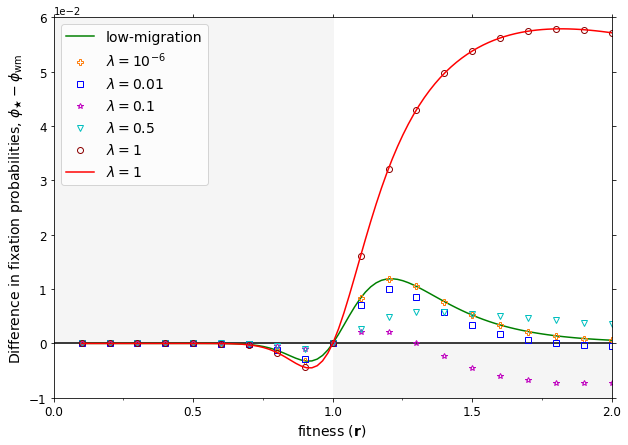

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#ylim=np.array(plt.gca().get_ylim())
ylim=[-0.01,0.06]
plt.xlim(left=0)

plt.xlim(right=2)
plt.ylim(top=ylim[1])
plt.ylim(bottom=ylim[0])
plt.fill_between(np.linspace(0,1,20),y1=0,y2=ylim[1], color='whitesmoke')
plt.fill_between(np.linspace(1.,2,20),y1=ylim[0],y2=0, color='whitesmoke')
ax.axhline(y=0, color='k')

ax.plot(Fitness1,fix_prob_star_patch(Fitness1)-fix_prob_well_mixed(Fitness1,local_size*patch_number), color='g',label='low-migration')
ax.plot(Fitness, numerical_fix_prob_06[:,1]-fix_prob_well_mixed(Fitness,local_size*patch_number) ,'P',color='tab:orange',markerfacecolor='none', label='$\lambda= 10^{-6}$')
ax.plot(Fitness, numerical_fix_prob_l_001[:,1]-fix_prob_well_mixed(Fitness,local_size*patch_number) ,'s',color='b',markerfacecolor='none', label='$\lambda= 0.01$')
ax.plot(Fitness,numerical_fix_prob_l_01[:,1]-fix_prob_well_mixed(Fitness,local_size*patch_number), '*',color='m',markerfacecolor='none', label='$\lambda=0.1$')
ax.plot(Fitness, numerical_fix_prob_l_05[:,1]-fix_prob_well_mixed(Fitness,local_size*patch_number) ,'v',color='c',markerfacecolor='none', label='$\lambda= 0.5$')
ax.plot(Fitness, numerical_fix_prob_l_1[:,1]-fix_prob_well_mixed(Fitness,local_size*patch_number) ,'o',color='darkred',markerfacecolor='none', label='$\lambda= 1$')
ax.plot(Fitness1, phi(Fitness1,local_size,local_size*(patch_number-1))-fix_prob_well_mixed(Fitness1,local_size*patch_number), color='r', label='$\lambda= 1$')
ax.tick_params(labelsize=12, direction='out',top=True, right=True)
ax.set_xlabel(r'fitness ($\bf{r}$) ',fontsize=14)
ax.set_ylabel(r"Difference in fixation probabilities, $\phi_{\bigstar}- \phi_{\rm wm} $",fontsize=14)

plt.legend(fontsize=14)
plt.show()